In [198]:
!pip install control
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import Symbol, solve, nsolve

In [199]:
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
T2m = np.array([12, 12, 12.5, 13.1, 14, 14.8, 15.4, 16.1, 16.4, 16.8, 16.9, 17.0, 16.9, 17.0, 16.9])

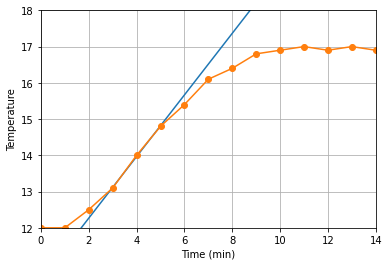

In [200]:
time_fit = time[3:6]
T2m_fit = T2m[3:6]

m,b = np.polyfit(time_fit, T2m_fit, 1)
tangent = m*np.linspace(0,9) + b
time_tangent = np.linspace(0,9) 

plt.plot(time_tangent, tangent)
plt.plot(time, T2m, marker = 'o',)
plt.ylabel('Temperature')
plt.xlabel('Time (min)')
plt.ylim([12,18])
plt.xlim([0, 14])
plt.grid()

In [201]:
# Solving for theta

x = Symbol('x')
solve(m * x + b - 12, x)

[1.68627450980394]

In [202]:
# Solving for tau 

x = Symbol('x')
solve(m * x + b - 17, x)

[7.56862745098041]

In [203]:
time = np.linspace(0, 30, 301)

In [204]:
# Using Table 12.1 on Page 207, Model H is selected
# Given tauC = tau / 3

# Given Values
K_V = 0.9
K_IP = 0.75
Ps0 = 18
Ps  = 20
KpKm = (T2m[-1] - T2m[0]) / (Ps - Ps0)
K = K_V * K_IP * KpKm

theta = 1.7 # solved from above 
tau = 7.6 - theta # solved from above

tauC = tau / 3
Kc_IMC = (1 / K) * ((tau + theta / 2) / (tauC + theta / 2))
tauI_IMC = tau + theta / 2
tauD_IMC = (tau * theta) / (2 * tau + theta)

In [205]:
Gd = tf([KpKm], [tau,1]) * tf(*pade(theta, n=3))
G =  tf([K], [tau, 1]) * tf(*pade(theta, n=3))

In [206]:
def simulation (Kc, tauI, tauD):

    Gc = tf([tauD, Kc, 1/tauI], [1,0]) # controller transfer function
    GOL = G*Gc                         # G_OL = G*Gc
    Y_D = Gd / (1 + GOL)               # closed loop transfer function
    y, t = step(Y_D, time)

    return y

In [207]:
def results(y, model):

  plt.grid()
  plt.plot(time, y, label = 'IMC')
  plt.xlabel('Time (min)')
  plt.ylabel('y')
  plt.title(model + " Model")
  print('K: ' + '{0:.3f}'.format(K))
  print('Kc: ' + '{0:.3f}'.format(Kc))
  print('theta: ' + '{0:.3f}'.format(theta))
  print('tau: ' + '{0:.3f}'.format(tau))
  print('tauC: ' + '{0:.3f}'.format(tauC))
  print('tauI: ' + '{0:.3f}'.format(tauI))
  print('tauD: ' + '{0:.3f}'.format(tauD))

K: 1.654
Kc: 4.080
theta: 1.700
tau: 5.900
tauC: 1.967
tauI: inf
tauD: 0.000


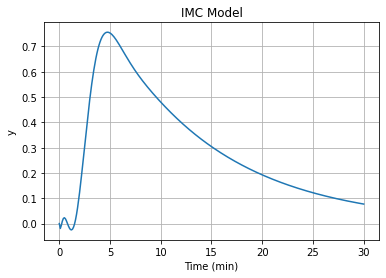

In [220]:
y_IMC = simulation (Kc_IMC, tauI_IMC, tauD_IMC)
#results(y_IMC, "IMC")

In [209]:
# Using Table 12.4 on Page 211, PID Disturbance is selected
# Y = A*(theta/tau)^B

PA = 1.357
PB = -0.947
IA = 0.842
IB = -0.738
DA = 0.381
DB = 0.995

Kc_ITAE = (PA * (theta/tau)**PB) / K
tauI_ITAE = tau / (IA * (theta/tau)**IB)
tauD_ITAE = tau * (DA * (theta/tau)**DB)

K: 1.654
Kc: 4.080
theta: 1.700
tau: 5.900
tauC: 1.967
tauI: inf
tauD: 0.000


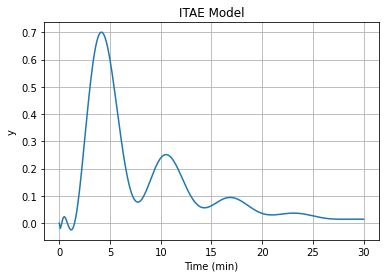

In [210]:
y_ITAE = simulation (Kc_ITAE, tauI_ITAE, tauD_ITAE)
#results(y_ITAE, "ITAE")

K: 1.654
Kc: 4.080
theta: 1.700
tau: 5.900
tauC: 1.967
tauI: inf
tauD: 0.000


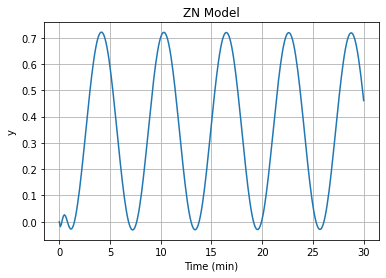

In [221]:
# Using Table 12.7 on Page 215, PID is selected

# Kcu is obtained by trial and error
Kcu = 6.15
Kc_ZN_test = 0.6 * Kcu

tauI_ZN_test = np.inf
tauD_ZN_test = 0

y_ZN_test = simulation (Kc_ZN_test, tauI_ZN_test, tauD_ZN_test)
results(y_ZN_test, "ZN")

In [212]:
# Find the maximum of period 
y_ZN_test.max()

# Find array that encompasses two instances of the maximum
y_ZN_period = y_ZN_test[41:103]

#The length of the period
len(y_ZN_period)

print("Pu is " + str(len(y_ZN_period)/10) + " minutes")

Pu is 6.2 minutes


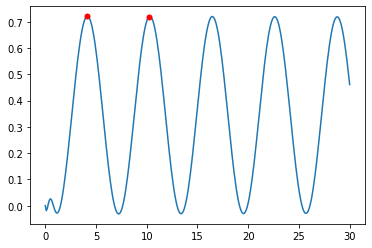

In [213]:
# Check accuracy of period 

plt.plot(time, y_ZN_test)
plt.plot(time[41], y_ZN_test[41], marker='o', markersize=5, color="red")
plt.plot(time[102], y_ZN_test[102], marker='o', markersize=5, color="red")


In [214]:
# Using Table 12.7 on Page 215, PID is selected

Pu = 6.2
Kcu = 6.15
Kc_ZN = 3.69

tauI_ZN = Pu / 2
tauD_ZN = Pu / 8

K: 1.654
Kc: 4.080
theta: 1.700
tau: 5.900
tauC: 1.967
tauI: inf
tauD: 0.000


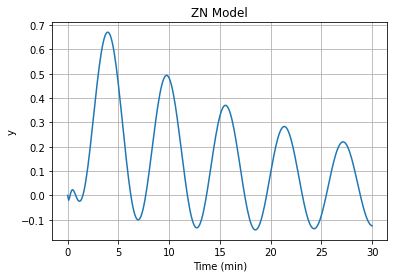

In [218]:
y_ZN = simulation (Kc_ZN, tauI_ZN, tauD_ZN)
#results(y_ZN, "ZN")

Text(0, 0.5, 'y')

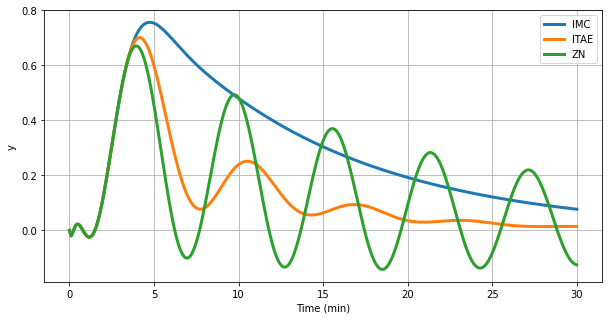

In [231]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(time, y_IMC, label = 'IMC', linewidth = 3)
plt.plot(time, y_ITAE, label = 'ITAE', linewidth = 3)
plt.plot(time, y_ZN, label = 'ZN', linewidth = 3)
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('y')